# Here will we analyze the steered sims
most of this info is taken from ABMD analysis

You only need to run this first section of code for the other parts, and then you can skip around

This assumes you have run `input_maker` and have a `string0.txt` file which you can parse, as well as a `cv.pkl` file

You may have issues with Trust in this notebook because we are calling bash commands from here

In [1]:
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
import os.path
import subprocess
import pickle
import pandas as pd
from MDAnalysis.analysis import distances
import sys
import math

### User inputs

- `trajdir` - where can you find state trajectories
- `trajname` - name of directory
- `n_beads` - how many beads in simulation. Even if you haven't finished sims and want to analyze, leave this as # beads because it will help us to parse `string0.txt`


### Data loading
Run `combine_confout.sh` which will take our inputs here to run `gmx editconf` on gro files, putting them together as PDBs and then concatenating PDB files.

To not get an error we should first make sure n_beads is correct (so that you can run this script while still running simulations, even if they aren't done)

## table of contents:
- [Parse all files](#start) - run each time
- [Demystifying res progress](#demyst) - steered using Oliver code only
- [Gate COM detection](#gate_progress) - either steered or TMD
- [RMSD](#rmsd) - either steered or TMD
- [COLVAR file parsing](#COLVAR) - TMD only

Define here if you are using targeted MD or not


In [79]:
targeted_MD = True
skip25 = False

We do this because there are different ways of loading trajectory depending on the method of MD used. Still have to define `trajname`
 <a id='start'></a>


In [80]:
if not targeted_MD:
    trajdir = '../../all_state_running'

    #trajname = 'Occ-InOcc'
    trajname = 'efflux_demyst_gate_CV'

    n_beads = 12

    for n in range(n_beads):
        if os.path.isfile('%s/%s/md/0/%i/restrained/confout.gro' % (trajdir, trajname, n)):
            pass
        else:
            n_beads = n - 1
            break

    print('%s beads detected so far, Universe PDB will be this many frames' % (n_beads))


    ## call the combine script. Will combine at max n_beads. If not finished, will combine as many as possible
    subprocess.check_call("./combine_confout.sh %s %s %s %s" % (str(n_beads), trajname, trajdir, str(trajdir.split('/')[-1])), shell=True)

elif targeted_MD:
    trajdir = '../../state_by_state_running/targeted_MD/influx_apo_all_heavy'
    trajname = 'OutOcc-InOcc'
    
    ## simulation name: [start_ref, end_ref]
    sim_ref_dict = {"InOpen-InOcc":["IN.start.gro", "IN-OCC.start.gro"],\
                    "InOcc-Occ":["InOpen-InOcc.9600ps.gro", "OCC.start.gro"],\
                    "Occ-OutOcc":["InOcc-Occ.8600ps.gro", "OUT-OCC.start.gro"],\
                    "OutOcc-OutOpen":["Occ-OutOcc.7700ps.gro", "OUT.equilib.200ns.gro"],\
                    "InOcc-OutOcc":["InOpen-InOcc.9600ps.gro", "OUT-OCC.start.gro"],\
                   
                    #influx
                    "OutOpen-OutOcc":["OUT.equilib.200ns.gro", "OUT-OCC.start.gro"],\
                    "OutOcc-Occ":["OutOpen-OutOcc.11200ps.gro", "OCC.start.gro"],\
                    "Occ-InOcc":["OutOcc-Occ.10000ps.gro", "IN-OCC.start.gro"],\
                    "InOcc-InOpen":["Occ-InOcc.8100ps.gro", "IN.start.gro"],\
                    "OutOcc-InOcc":["OutOpen-OutOcc.11200ps.gro", "IN-OCC.start.gro"],\
                    
                    #all 
                   "OutOpen-InOpen":["OUT.equilib.200ns.gro", "IN.start.gro"],\
                    "InOpen-OutOpen":["IN.start.gro", "OUT.equilib.200ns.gro"]}



Load a few more input files, again still have to change based on what simulation you are using


In [81]:
if not targeted_MD:
    u = mda.Universe('./confout_temp/%s.%s.%i.frames.pdb' % (str(trajdir.split('/')[-1]), trajname, n_beads))
    #target_str = mda.Universe('%s/%s/topology/end.gro' % (trajdir, trajname))

    start_ref = mda.Universe('%s/%s/topology/start.gro' % (trajdir, trajname))
    if 'efflux' in trajname:
        target_str = mda.Universe('../ref_models/OUT.equilib.200ns.gro')
        start_name = 'In Open'
        end_name = 'Out Open'
    elif 'influx_BFRU_demyst' in trajname:
        target_str = mda.Universe('../ref_models/IN.start.gro')
        start_name = 'Out Open'
        end_name = 'In Open'
    elif 'influx_BFRU_gate' in trajname:
        target_str = mda.Universe('../ref_atom_sim/IN.548ns.gro')
        start_name = 'Out Open'
        end_name = 'In Open'    


    cvs, ndx_groups = pickle.load(open("cv.pkl", "rb"))

    
    
    
    
elif targeted_MD:
    start_name = trajname.split('-')[0]
    end_name = trajname.split('-')[1]
    if skip25:
        u = mda.Universe(f'{trajdir}/{trajname}/{sim_ref_dict[trajname][0]}', f'{trajdir}/{trajname}/{trajname}.skip25.xtc')
    else:
        u = mda.Universe(f'{trajdir}/{trajname}/{sim_ref_dict[trajname][0]}', f'{trajdir}/{trajname}/{trajname}.xtc')
        
    start_ref = mda.Universe(f'{trajdir}/{trajname}/{sim_ref_dict[trajname][0]}')
    target_str = mda.Universe(f'{trajdir}/{trajname}/{sim_ref_dict[trajname][1]}')

# Find distance to demystifying CVs
## skip for **targeted MD** and go to [gate progress](#gate_progress)
 <a id='demyst'></a>


#### This will find the difference between the `end.gro` (or other specified gro file) vs the `confout.gro` files from each steered sim (saved in `confout_temp` as one concatenated trajectory) 

First, get the information from the `cvs.pkl` file (about residue pairs and their corresponding indices)

The calculation can take a minute or two, if you don't want to wait, set `calculate_dists` to `False`.

`distance_arr` is shaped as #CVs, #beads (so each row is 1 CV, and each column is one bead). 
In the case of `target_str` loading, `distance_arr` will be (#CVs, 1)

In [6]:
def get_distances(traj, calculate_dists, save_dists):
    
    
    if not calculate_dists:
        distance_arr = np.load('distance_arrays/distances_demystifying_CVs.%s.%s.npy' %(str(trajdir.split('/')[-1]), trajname))

    else:
        distance_arr = np.zeros((len(cvs), len(traj.trajectory))) 
    
    
    # get resname pairs, for labeling dataframes and graphs
    resname_pairs = []
    
    for cv_index, cv_num in enumerate(cvs):
        resname_cv1 = list(ndx_groups)[cv_num[0]-1]
        resname_cv2 = list(ndx_groups)[cv_num[1]-1]
        resname_pairs.append((int(resname_cv1[2:].split('_')[0]), int(resname_cv2[2:].split('_')[0])))  #only save names      
    
    
        if calculate_dists:
            # get atoms from traj
            distance = []
            feat1 = traj.select_atoms(ndx_groups[resname_cv1])
            feat2 = traj.select_atoms(ndx_groups[resname_cv2])
            for timestep in traj.trajectory:
                distance.append(float(distances.dist(feat1, feat2)[2]))  #index 2 is actual distances, 0 and 1 are resids

            distance_arr[cv_index] = distance
    
        #write progress
        sys.stdout.write("\r%d / %s done" %(cv_index + 1, len(cvs)))
        sys.stdout.flush()
        
    if save_dists:
        np.save('distance_arrays/distances_demystifying_CVs.%s.%s.npy' %(str(trajdir.split('/')[-1]), trajname), distance_arr)
    
    return resname_pairs, distance_arr

In [7]:
resname_pairs, distance_arr = get_distances(u, calculate_dists = True, save_dists = True)
resname_pairs, target_dist = get_distances(target_str, calculate_dists = True, save_dists = False)

# take difference, and make into nm from A
distance_arr = np.abs(target_dist - distance_arr) / 10
distance_to_target = pd.DataFrame(distance_arr.T, columns=resname_pairs)

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/core/selection.py:763: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)


30 / 30 done

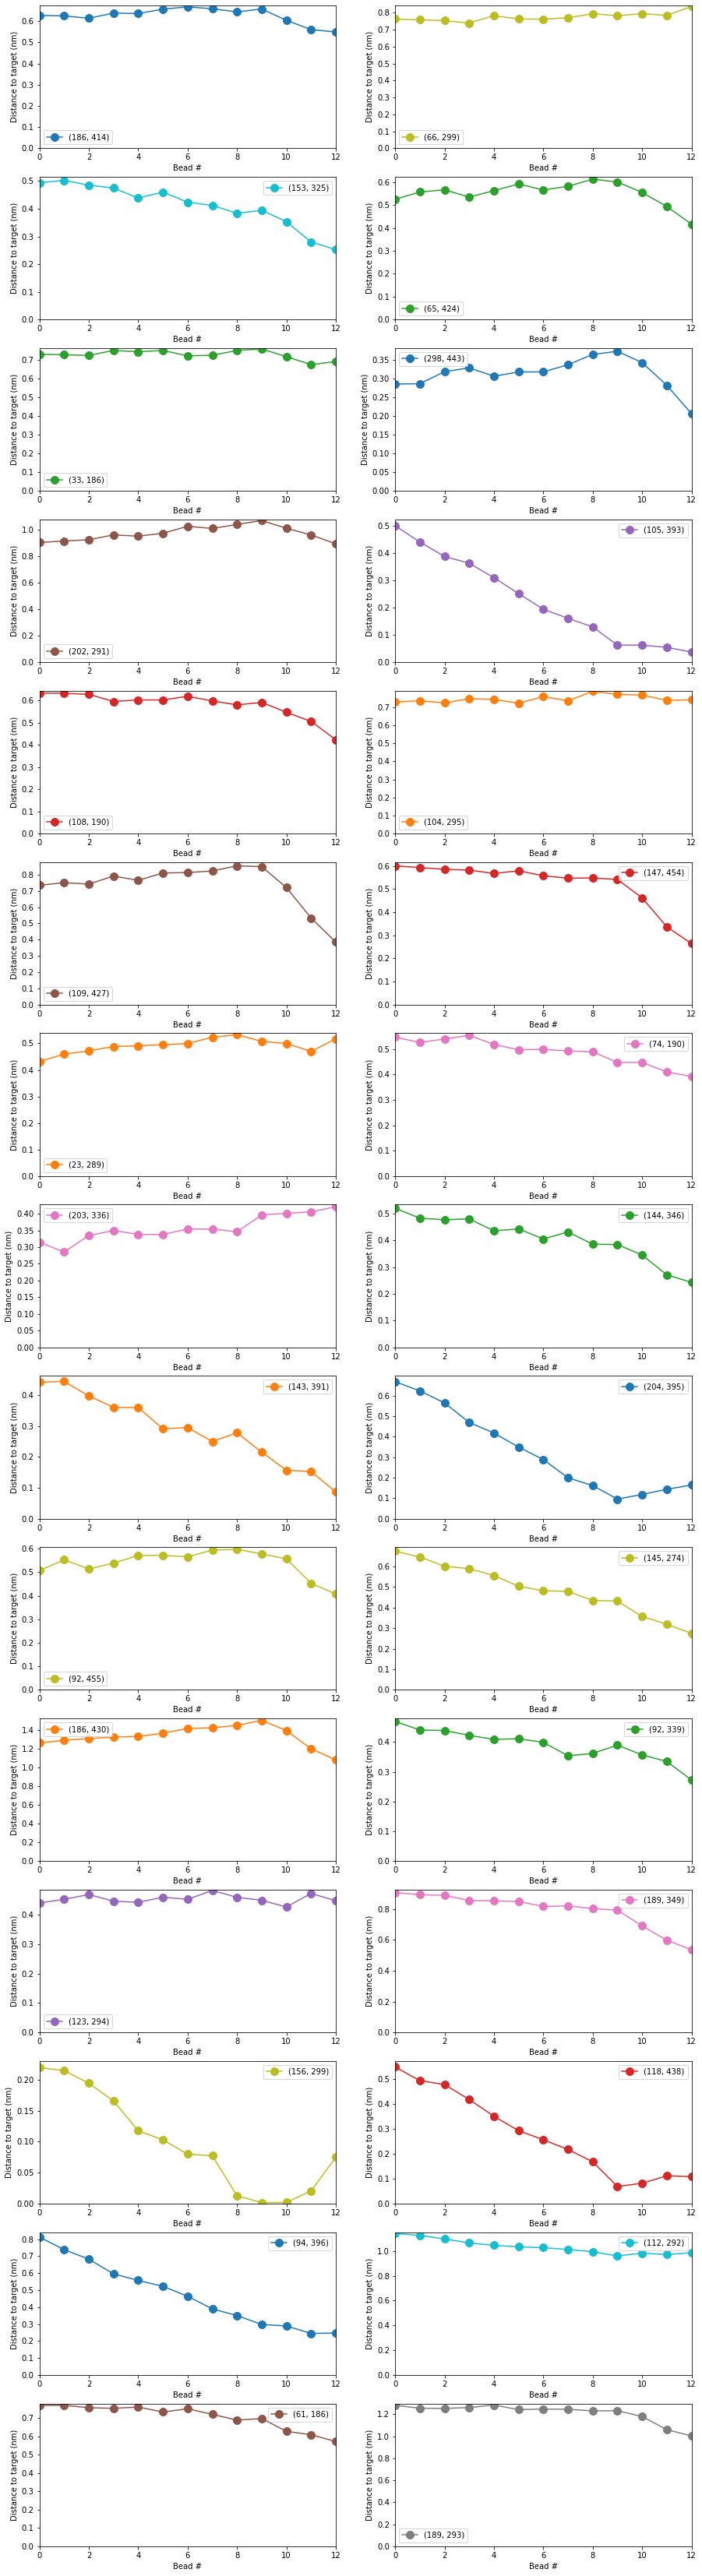

In [8]:
#adapt plot size - generally good to have it 15 x double length of CVs, just looks best I have found
figsize = (15, int(len(resname_pairs)) *2)


# adapt color bar
cmap = plt.cm.get_cmap('tab10')
np.random.seed(479)
colors = cmap(np.random.random((int(len(resname_pairs)))))[:,:-1]

fig, axes = plt.subplots(math.ceil(len(resname_pairs) / 2), 2, figsize=figsize)

#if not divisible by zero, delete the final axes
if len(resname_pairs) % 2 != 0:
    fig.delaxes(axes[math.floor(len(resname_pairs) / 2) , 1])
    
for i, cv_data in enumerate(distance_to_target):
    ax = distance_to_target[cv_data].plot(ax = axes.flatten()[i], style = '.-', markersize = 20, label = cv_data, color = tuple(colors[i]))
    ax.legend() 
    ax.set_xlim(0, n_beads)
    ax.set_ylim(0)
    ax.set_xlabel('Bead #')
    ax.set_ylabel('Distance to target (nm)')
    
    
plt.savefig('../images_figs/steered_progress_plots/demyst_dists/%s_simulation.%s_state.%s_beads.demystifying_CV_progress.png' \
            %(trajdir.split('/')[-1], trajname, n_beads), dpi = 200)

 <a id='gate_progress'></a>
 

# Gate progress
#### This will measure EC and IC gate distance vs the target structure. This won't need strings0.txt, this needs `end.gro` 

If you want to compare the gate to another structure, just change the `target_str`


In [82]:
gate_EC = [(30,37), (289,295)]
gate_IC = [(136,145), (386,394)]

In [83]:
gate_EC_dists = []
gate_IC_dists = []

def get_tm_COM(md_uni):
    tm1 = md_uni.select_atoms('resid %i-%i' %(gate_EC[0][0], gate_EC[0][1])).center_of_mass()
    tm7 = md_uni.select_atoms('resid %i-%i' %(gate_EC[1][0], gate_EC[1][1])).center_of_mass()
    tm4 = md_uni.select_atoms('resid %i-%i' %(gate_IC[0][0], gate_IC[0][1])).center_of_mass()
    tm10 = md_uni.select_atoms('resid %i-%i' %(gate_IC[1][0], gate_IC[1][1])).center_of_mass()    

    return tm1,tm7,tm4,tm10

for timestep in u.trajectory:
    tm1,tm7,tm4,tm10 = get_tm_COM(u)

    gate_EC_dists.append(float(distances.distance_array(tm1, tm7)) / 10)
    gate_IC_dists.append(float(distances.distance_array(tm4, tm10))/ 10) #keep in nm

### for target_str, same principle:
tm1,tm7,tm4,tm10 = get_tm_COM(target_str)

target_EC = float(distances.distance_array(tm1, tm7)) / 10
target_IC = float(distances.distance_array(tm4, tm10)) / 10

start_EC = gate_EC_dists[0]
start_IC = gate_IC_dists[0]

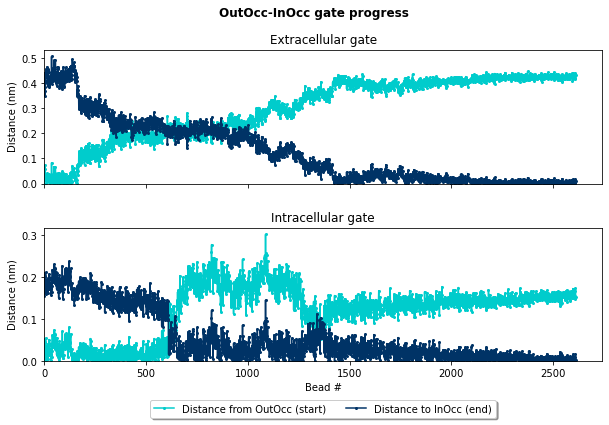

In [84]:
c = ['#00CCCC', '#003366']
figsize = (10, 6)
markersize = 2
savefig = False


fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex = True, figsize = figsize)

ax1.plot(np.arange(len(gate_EC_dists)), abs(start_EC - np.array(gate_EC_dists)), \
         label = "Distance from %s (start)" %start_name, color = c[0],\
        marker = 'o', markersize = markersize)
ax1.plot(np.arange(len(gate_EC_dists)), abs(target_EC - np.array(gate_EC_dists)),\
         label = "Distance to %s (end)" %end_name, color = c[1],
        marker = 'o', markersize = markersize)
ax1.set_title("Extracellular gate")
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.set_ylabel('Distance (nm)')

ax2.plot(np.arange(len(gate_IC_dists)), abs(start_IC - np.array(gate_IC_dists)),\
         label = "Distance from %s (start)" %start_name, color = c[0],\
        marker = 'o', markersize = markersize)
ax2.plot(np.arange(len(gate_IC_dists)), abs(target_IC - np.array(gate_IC_dists)),\
         label = "Distance to %s (end)" %end_name, color = c[1],\
        marker = 'o', markersize = markersize)
ax2.set_title("Intracellular gate")
ax2.set_xlim(0)  
ax2.set_ylim(0)
ax2.set_xlabel('Bead #')
ax2.set_ylabel('Distance (nm)')

box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, ncol=2)

fig.suptitle('%s gate progress' %(trajname), fontweight='bold')

if savefig:
    plt.savefig('../images_figs/steered_progress_plots/gate_dists/%s_simulation.%s_state.%s_beads.gate_progress.png' \
            %(trajdir.split('/')[-1], trajname, n_beads), dpi = 200)

# Make EC gate and IC gate plots as scatter to compare to classic KDE plot

Text(0.5, 1.0, 'Efflux apo heavy atom TMD')

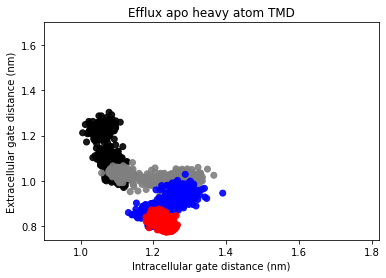

In [85]:
c = np.empty(len(gate_IC_dists), dtype='object')
if 'influx' in trajdir and skip25:
    c[:113] = '#000000' #OutOpen - OutOcc
    c[113:222] = '#004F90'        #OutOcc-Occ
    c[222:304] = '#5180C6'        #Occ- InOcc
    c[304:] = '#99CCFF'          #InOcc-InOpen
elif 'efflux' in trajdir and skip25:
    c[:97] = '#000000' #InOpen - InOcc
    c[97:184] = '#004F90'        #InOcc-Occ
    c[184:262] = '#5180C6'        #Occ- OutOcc
    c[262:] = '#99CCFF'          #OutOcc-OutOpen
    
elif not skip25:    
    c[:500] = '#000000'
    c[500:1000] = 'grey'
    c[1000:1500] = 'blue'
    c[1500:] = 'red'

a = 0.9
plt.scatter(gate_IC_dists, gate_EC_dists, color = c, alpha = a)

plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")
plt.title("Efflux apo heavy atom TMD")

In [148]:
len(gate_EC_dists)

2157

# compare overall EF and IF for entire transitions (this loads both trajs now, don't need to get from loading page above)


In [47]:
def plot_comparison(trajdir, trajname, color, a = 0.4, label = None, skip25 = None, highlight_frames = None):
    if skip25:
        traj = mda.Universe(f'{trajdir}/{trajname}/{sim_ref_dict[trajname][0]}', f'{trajdir}/{trajname}/{trajname}.skip25.xtc')
    else:
        traj = mda.Universe(f'{trajdir}/{trajname}/{sim_ref_dict[trajname][0]}', f'{trajdir}/{trajname}/{trajname}.xtc')
        
    gate_EC_dists = []
    gate_IC_dists = []
    for timestep in traj.trajectory:
        tm1,tm7,tm4,tm10 = get_tm_COM(traj)
        gate_EC_dists.append(float(distances.distance_array(tm1, tm7)) / 10)
        gate_IC_dists.append(float(distances.distance_array(tm4, tm10))/ 10) #keep in nm
    gate_EC_dists = np.array(gate_EC_dists)
    gate_IC_dists = np.array(gate_IC_dists)

    if not highlight_frames:
        plt.scatter(gate_IC_dists, gate_EC_dists, label=label, alpha = a, color = color)
    
    if highlight_frames:
        plt.scatter(gate_IC_dists[highlight_frames], gate_EC_dists[highlight_frames],\
                    label=label, alpha = 1, color = color, s=100, edgecolor = 'black')

    plt.xlim(0.9,1.82)
    plt.ylim(0.74, 1.7)
    plt.ylabel("Extracellular gate distance (nm)")
    plt.xlabel("Intracellular gate distance (nm)")
    plt.legend()

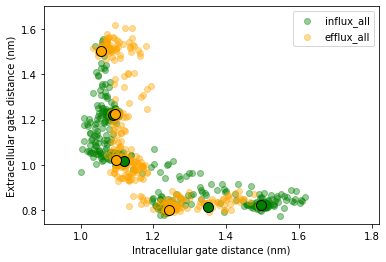

In [48]:
indir = '../../state_by_state_running/targeted_MD'

#first plot the entire trajectory
plot_comparison(trajdir = f'{indir}/influx_apo_all_heavy', trajname = 'OutOpen-InOpen', label = 'influx_all',\
               color = 'green', skip25 = True)
plot_comparison(trajdir = f'{indir}/efflux_apo_all_heavy', trajname = 'InOpen-OutOpen', label = 'efflux_all',\
               color = 'orange', skip25 = True)


#best to plot highlight_frames after you plot everything else, so they show up on top, 
#this is why we load it all again. don't add label here for redundancy
plot_comparison(trajdir = f'{indir}/influx_apo_all_heavy', trajname = 'OutOpen-InOpen',\
               color = 'green', skip25 = True, highlight_frames = [112,220,302,408])
plot_comparison(trajdir = f'{indir}/efflux_apo_all_heavy', trajname = 'InOpen-OutOpen', \
               color = 'orange', skip25 = True, highlight_frames = [96,182,259,350])

# Compare `InOcc-OutOcc` vs `OutOcc-InOcc` vs simulations passing through occluded state



/home/semccomas/anaconda3/lib/python3.8/site-packages/MDAnalysis/coordinates/XDR.py:216: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


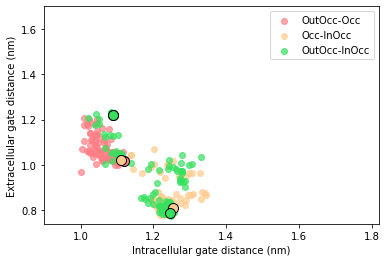

In [78]:
indir = '../../state_by_state_running/targeted_MD'
a = 0.7

plot_comparison(trajdir = f'{indir}/influx_apo_all_heavy', trajname = 'OutOcc-Occ', label = 'OutOcc-Occ',\
               color = '#FF7F85', skip25 = True, a = a)
plot_comparison(trajdir = f'{indir}/influx_apo_all_heavy', trajname = 'Occ-InOcc', label = 'Occ-InOcc',\
               color = '#FFCC8E', skip25 = True, a = a)
plot_comparison(trajdir = f'{indir}/influx_apo_all_heavy', trajname = 'OutOcc-InOcc', label = 'OutOcc-InOcc',\
               color = '#37E15F', skip25 = True, a = a)


plot_comparison(trajdir = f'{indir}/influx_apo_all_heavy', trajname = 'OutOcc-Occ',\
               color = '#FF7F85', skip25 = True, a = 1, highlight_frames = [0,-1])
plot_comparison(trajdir = f'{indir}/influx_apo_all_heavy', trajname = 'Occ-InOcc',\
               color = '#FFCC8E', skip25 = True, a = 1, highlight_frames = [0,-1])
plot_comparison(trajdir = f'{indir}/influx_apo_all_heavy', trajname = 'OutOcc-InOcc',\
               color = '#37E15F', skip25 = True, a = 1, highlight_frames = [0,-1])



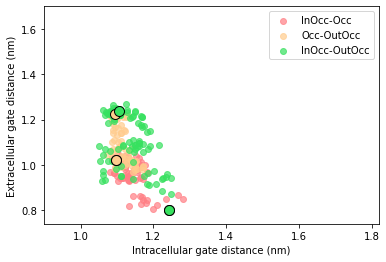

In [69]:
indir = '../../state_by_state_running/targeted_MD'
a = 0.7

plot_comparison(trajdir = f'{indir}/efflux_apo_all_heavy', trajname = 'InOcc-Occ', label = 'InOcc-Occ',\
               color = '#FF7F85', skip25 = True, a = a)
plot_comparison(trajdir = f'{indir}/efflux_apo_all_heavy', trajname = 'Occ-OutOcc', label = 'Occ-OutOcc',\
               color = '#FFCC8E', skip25 = True, a = a)
plot_comparison(trajdir = f'{indir}/efflux_apo_all_heavy', trajname = 'InOcc-OutOcc', label = 'InOcc-OutOcc',\
               color = '#37E15F', skip25 = True, a = a)


plot_comparison(trajdir = f'{indir}/efflux_apo_all_heavy', trajname = 'InOcc-Occ',\
               color = '#FF7F85', skip25 = True, a = 1, highlight_frames = [0,-1])
plot_comparison(trajdir = f'{indir}/efflux_apo_all_heavy', trajname = 'Occ-OutOcc',\
               color = '#FFCC8E', skip25 = True, a = 1, highlight_frames = [0,-1])
plot_comparison(trajdir = f'{indir}/efflux_apo_all_heavy', trajname = 'InOcc-OutOcc',\
               color = '#37E15F', skip25 = True, a = 1, highlight_frames = [0,-1])


# RMSD compared to start and end coordinates
 <a id='rmsd'></a>


In [51]:
import MDAnalysis.analysis.rms


start_RMSD = MDAnalysis.analysis.rms.RMSD(u, start_ref,
           select="backbone", center = True, \
            groupselections=["backbone and (resid 1-51 or resid 265-300 or resid 118-146 or resid 364-395)",\
                             "backbone and (resid 1-205 or resid 265-455)"])  
start_RMSD.run()


end_RMSD = MDAnalysis.analysis.rms.RMSD(u, target_str,
           select="backbone",center = True, \
            groupselections=["backbone and (resid 1-51 or resid 265-300 or resid 118-146 or resid 364-395)",\
                             "backbone and (resid 1-205 or resid 265-455)"])  
end_RMSD.run()

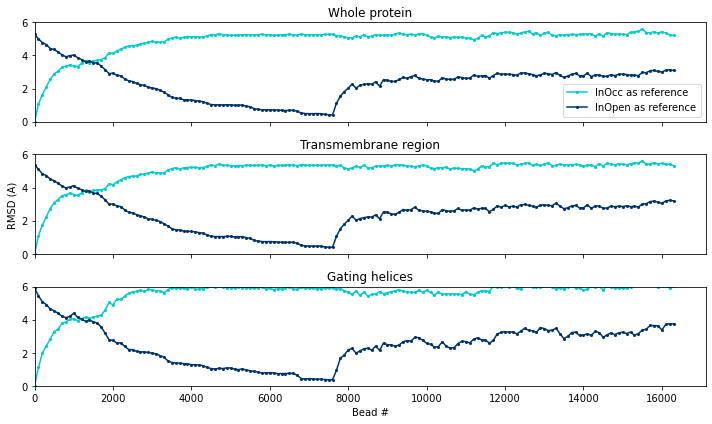

In [55]:
#TODO- fix all actual RMSDs
start_rmsd = start_RMSD.rmsd.T   # transpose makes it easier for plotting
end_rmsd = end_RMSD.rmsd.T   # transpose makes it easier for plotting
savefig = False

time = start_rmsd[1]
ylim = (0,6)

c = ['#00CCCC', '#003366']
figsize = (10, 6)
markersize = 2

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, sharex = True, figsize = figsize)

ax1.plot(time, start_rmsd[2], label="%s as reference" %start_name, color = c[0], marker = 'o', markersize = markersize)
ax3.plot(time, start_rmsd[3], color = c[0], marker = 'o', markersize = markersize)
ax2.plot(time, start_rmsd[4], color = c[0], marker ='o', markersize = markersize)


ax1.plot(time, end_rmsd[2], label="%s as reference" %end_name, color = c[1], marker = 'o', markersize = markersize)
ax3.plot(time, end_rmsd[3], color = c[1], marker = 'o', markersize = markersize)
ax2.plot(time, end_rmsd[4], color = c[1], marker ='o', markersize = markersize)

ax1.set_title('Whole protein')
ax3.set_title('Gating helices')
ax2.set_title('Transmembrane region')


plt.xlim(0)
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)
ax3.set_ylim(ylim)

ax3.set_xlabel("Bead #")
ax2.set_ylabel('RMSD (A)')

ax1.legend()
plt.tight_layout()

if savefig:
    plt.savefig('../images_figs/steered_progress_plots/RMSD/%s_simulation.%s_state.%s_beads.RMSD.png' \
            %(trajdir.split('/')[-1], trajname, n_beads), dpi = 200)

# RMSF calculation
You can see where the protein is not aligning, especially useful for targeted MD
Currently you can dump out the final frame and then run rmsf calcs, and then plot it here. Hopefully I implement something better soon

`gmx trjconv -f OutOpen-OutOcc.xtc -dump 17540 -o OutOpen-OutOcc.17_5ns.gro -s OutOpen-OutOcc.tpr`


`gmx rmsf -f OutOpen-OutOcc.17_5ns.gro -s OUT-OCC.start.gro -xvg none -res -fit`

Or

`gmx rmsf -f OutOpen-OutOcc.xtc -s OUT-OCC.start.gro -xvg none -res -fit -b 15000` 

to show for the final chunk of the simulation


   select 1 for protein

([<matplotlib.axis.XTick at 0x7ffb5db57f40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

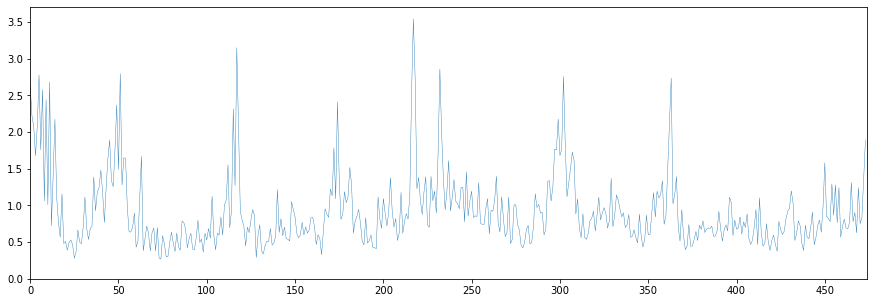

In [79]:
rmsf = np.loadtxt(f'{trajdir}/{trajname}/rmsf.xvg')

rmsf = np.nan_to_num(rmsf)
rmsf[:,1] = rmsf[:,1] * 10

f = plt.figure(figsize = (15,5))
plt.plot(rmsf[:,1], linewidth = 0.4)
plt.ylim(0)
plt.xlim(0, len(rmsf))
plt.xticks(np.arange(0, len(rmsf)+1, 50))

In [80]:
sorted_rmsf = np.argsort(rmsf[:,1])[-10:]

print("Max RMSF values are:")
for x in sorted_rmsf[::-1]:
    print(rmsf[x])

Max RMSF values are:
[218.      3.542]
[118.     3.15]
[233.      2.859]
[52.     2.797]
[6.    2.778]
[303.      2.757]
[364.      2.735]
[219.      2.732]
[12.     2.685]
[1.    2.635]


# Salt bridge distance analysis

This exists in a bit of a different space than the above analysis, so we are loading new trajectories

In [192]:
# TEMPORARY
trajdir = '../../efflux_demyst_CV'

trajname = 'OutOcc-OutOpen'
#trajname = 'OutOpen-OutOcc'

In [193]:
model_dict = {'OutOpen-OutOcc':('OUT', 'OCC'), 'OutOcc-Occ':('OUT-OCC', 'OCC'), 'Occ-InOcc':('OCC', 'IN-OCC'), \
             'InOcc-InOpen':('IN-OCC', 'IN'), 'InOpen-InOcc':('IN', 'IN-OCC'), 'InOcc-Occ':('IN-OCC', 'OCC'),\
             'Occ-OutOcc':('OCC', 'OUT-OCC'), 'OutOcc-OutOpen':('OUT-OCC', 'OUT')}

start_model = mda.Universe('../ref_models/%s.start.gro' % (model_dict[trajname][0]) )
end_model = mda.Universe('../ref_models/%s.start.gro' % (model_dict[trajname][1]) )

start_sim = mda.Universe('%s/%s/md/0/0/restrained/confout.gro' %(trajdir, trajname) )
end_sim = mda.Universe('%s/%s/md/0/15/restrained/confout.gro' %(trajdir, trajname) )

Then we make a dataframe, one per plot and we have 4 plots. 


Each will calculate the distance for the bridge of the model and the simulation.

In [194]:
bridge1 = [145, 91, 401]  #most important is E145 to R401
bridge2 = [334, 152, 394, 330]   #most important is E394 to R152

#res = list(zip(bridge1, bridge1[1:] + bridge1[:1]))
#res = list(zip(bridge2, bridge2[1:] + bridge2[:1]))


def get_salt_dists(bridge, traj_model, traj_sim):
    distance_model = []
    distance_sim = []
    
    res = list(zip(bridge, bridge[1:] + bridge[:1]))   #pair up each bridge residue
    for (res1, res2) in res:
        feat1 = traj_model.select_atoms('resid %s and name CA' %res1)
        feat2 = traj_model.select_atoms('resid %s and name CA' %res2)
        distance_model.append(float(distances.dist(feat1,feat2)[2]))
        
        
        feat1 = traj_sim.select_atoms('resid %s and name CA' %res1)
        feat2 = traj_sim.select_atoms('resid %s and name CA' %res2)
        distance_sim.append(float(distances.dist(feat1,feat2)[2]))
    
    
    df = pd.DataFrame({'group':res, 'distance_model':distance_model, 'distance_sim':distance_sim})
    return(df)

bridge1_dist_start = get_salt_dists(bridge1, start_model, start_sim)
bridge1_dist_end = get_salt_dists(bridge1, end_model, end_sim)

bridge2_dist_start = get_salt_dists(bridge2, start_model, start_sim)
bridge2_dist_end = get_salt_dists(bridge2, end_model, end_sim)

In [195]:
bridge1_dist_start

,group,distance_model,distance_sim
0,"(145, 91)",9.771560,9.523387
1,"(91, 401)",12.459473,10.506369
2,"(401, 145)",9.491140,8.307509


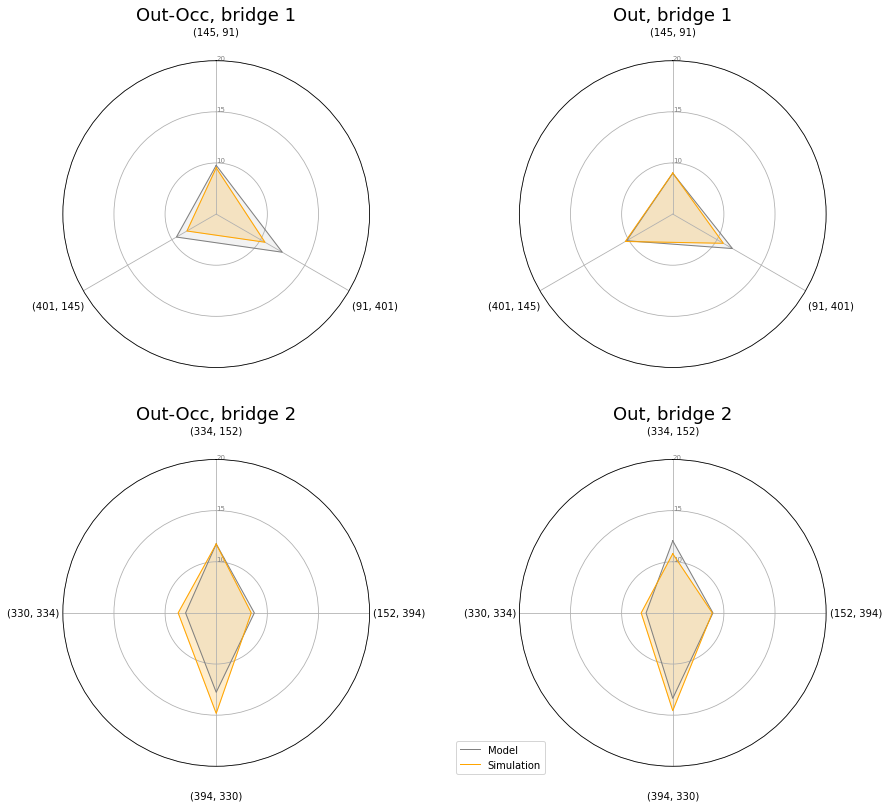

In [196]:
from math import pi 

def make_radar(bridge, plot_loc, title):
    # ------- PART 1: Create background

    # number of variable
    categories=bridge['group']
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(plot_loc, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels. Add a bit of a pad so numbers aren't so smushed
    plt.xticks(angles[:-1], categories)
    ax.tick_params(axis='both', which='both', pad=19)


    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,15,20], ["10","15","20"], color="grey", size=7)
    plt.ylim(5,20)



    # Ind1
    values=bridge['distance_model'].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="Model", color = 'grey')
    ax.fill(angles, values, 'b', alpha=0.1, color = 'grey')


    values=bridge['distance_sim'].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="Simulation", color = 'orange')
    ax.fill(angles, values, 'b', alpha=0.2, color = 'orange')
    
    ax.set_title(title, fontdict={'fontsize': 18, 'fontweight': 'medium'})

    
fig = plt.figure(figsize = (15,10))
make_radar(bridge1_dist_start, 221, '%s, bridge 1' % model_dict[trajname][0].title() )  #.title() will make it look nicer (IN-OCC --> In-Occ)
make_radar(bridge1_dist_end, 222, '%s, bridge 1' % model_dict[trajname][1].title() )
make_radar(bridge2_dist_start, 223, '%s, bridge 2' % model_dict[trajname][0].title() )  
make_radar(bridge2_dist_end, 224, '%s, bridge 2' % model_dict[trajname][1].title() )

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.2)


# Show the graph
plt.savefig('../images_figs/steered_progress_plots/salt_bridge/salt_bridge_radar.%s.%s.vs_models.png'\
           %(trajdir.split('/')[-1], trajname), dpi = 200)

In [197]:
#feat1 = start_ref.select_atoms('resid 334')
#feat2 = start_ref.select_atoms('resid 394')

#distances.distance_array(feat1,feat2)

#TODO - try to change this to be for actual contacts, not just CA

# For targeted MD - parsing the COLVAR file
 <a id='COLVAR'></a>


to interpret this output- can read [PLUMED documentation](https://www.plumed.org/doc-v2.6/user-doc/html/_m_o_v_i_n_g_r_e_s_t_r_a_i_n_t.html)

In [57]:
colvar = pd.read_csv(f'{trajdir}/{trajname}/COLVAR_all', delimiter= ' ', comment = '#')
colvar = colvar.iloc[::10, 1:]  # I read this out WAY too often on accident, so just skip every 1000 for now

colvar.columns = ['time (ps)', 'rmsd', 'restraint.bias', 'restraint.force2', 'restraint.rmsd_cntr',\
         'restraint.rmsd_work', 'restraint.rmsd_kappa', 'restraint.work']
colvar = colvar.set_index('time (ps)')

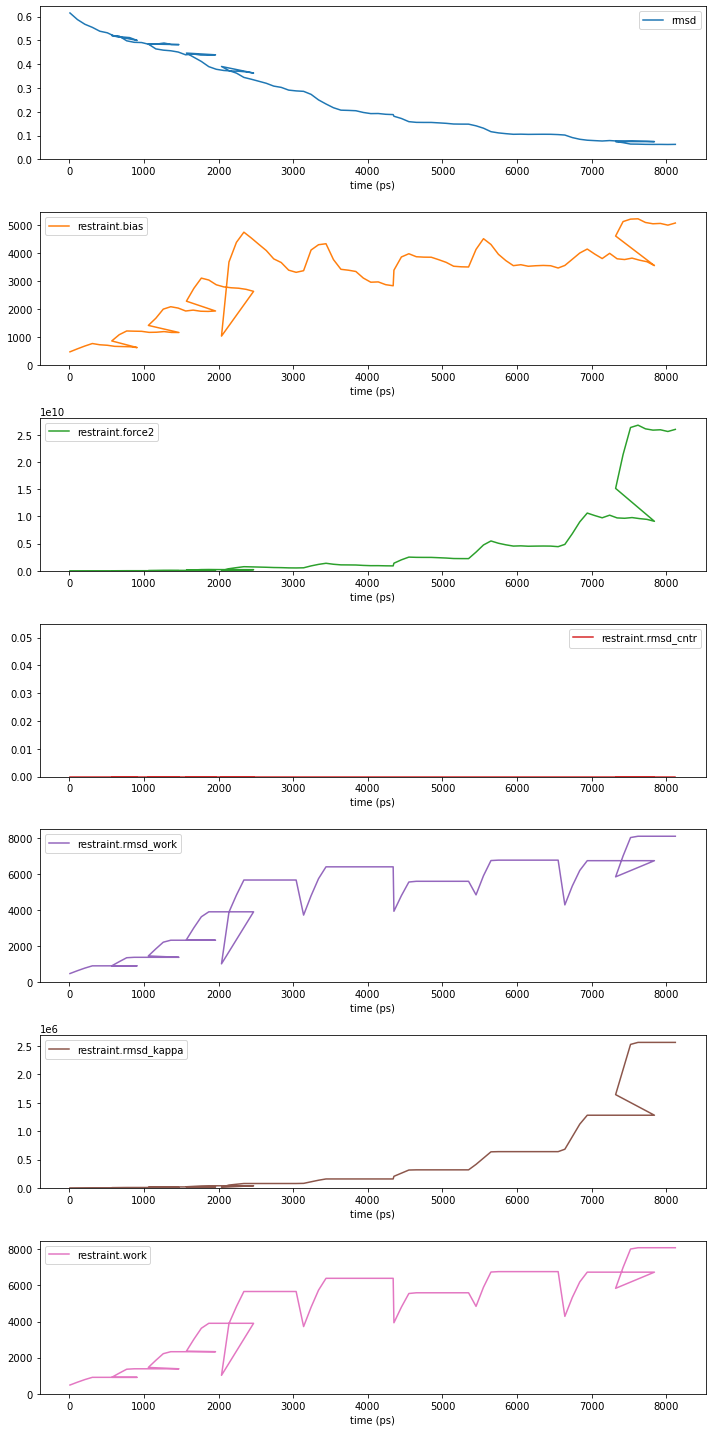

In [58]:
colvar.plot(subplots = True, figsize = (10,20), sharex = False, ylim = 0)
plt.tight_layout()
